In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

In [2]:
# Load previously cleaned model
bayes_df = pd.read_csv("models/clean_model.csv", index_col=0)
bayes_df.head()

,elisa,gada_trunc,ia2,m_iaa,znt8_c_arg,znt8_c_tryp,age_at_sample,any_fdr,label_early_stage,elisa_missing,gada_trunc_missing,ia2_missing,m_iaa_missing,znt8_c_arg_missing,znt8_c_tryp_missing,age_at_sample_missing,any_fdr_missing,label_single,era_uid
uid,,,,,,,,,,,,,,,,,,,
00032F0C-5916-4671-BB7B-A48314D14AF6,132.320000,8.5,0.1,1.0,0.1,0.1,3.78,0,0,0,0,0,0,0,0,0,0,0,pre-2016
0033DB11-56A2-4E3D-9B8F-0556819CF005,1.335415,0.1,0.1,14.7,0.1,0.1,3.10,0,0,0,0,0,0,0,0,0,0,1,2019-2021
005B2E43-F96E-406F-AB19-BECB1692A4C6,26.920000,0.1,0.1,0.7,0.1,0.1,3.92,0,0,0,0,0,0,0,0,0,0,0,pre-2016
00612B9E-AB0E-4E25-9078-219711028F73,54.409000,3.8,0.1,0.6,0.1,0.1,2.16,0,0,0,0,0,0,0,0,0,0,0,2016-2018
00731613-E23A-4DA4-849F-9D1762C9E3D7,130.640000,0.1,0.1,1.0,0.1,0.1,5.25,0,0,0,0,0,1,0,0,0,0,0,2022+


In [3]:
# Define 3-class label y:
# 0 = negative, 1 = single-positive, 2 = multiple/early-stage
# (label_early_stage and label_single should already be in clean_df)

def three_class_label(row):
    if row["label_early_stage"] == 1:
        return 2  # multiple / early-stage
    elif row["label_single"] == 1:
        return 1  # single positive
    else:
        return 0  # negative

bayes_df["y_class"] = bayes_df.apply(three_class_label, axis=1)

# Choose antibody columns to model generatively
ab_cols = ["gada_trunc", "ia2", "m_iaa", "znt8_c_arg", "znt8_c_tryp"]

# Log-transform antibody titers (add small epsilon to handle zeros)
EPS = 1e-3

for col in ab_cols:
    bayes_df[f"log_{col}"] = np.log(bayes_df[col] + EPS)

# Extract FDR flag as int (0/1)
bayes_df["fdr_flag"] = bayes_df["any_fdr"].fillna(0).astype(int)

# Optional: drop rows with missing labels or completely missing all ABs
mask_valid_label = bayes_df["y_class"].notna()
mask_any_ab = bayes_df[[f"log_{c}" for c in ab_cols]].notna().any(axis=1)
bayes_df = bayes_df[mask_valid_label & mask_any_ab].copy()

print("Bayesian modeling dataset shape:", bayes_df.shape)
bayes_df[["y_class", "fdr_flag"] + [f"log_{c}" for c in ab_cols]].head()

Bayesian modeling dataset shape: (4965, 26)


,y_class,fdr_flag,log_gada_trunc,log_ia2,log_m_iaa,log_znt8_c_arg,log_znt8_c_tryp
uid,,,,,,,
00032F0C-5916-4671-BB7B-A48314D14AF6,0,0,2.140184,-2.292635,0.001000,-2.292635,-2.292635
0033DB11-56A2-4E3D-9B8F-0556819CF005,1,0,-2.292635,-2.292635,2.687916,-2.292635,-2.292635
005B2E43-F96E-406F-AB19-BECB1692A4C6,0,0,-2.292635,-2.292635,-0.355247,-2.292635,-2.292635
00612B9E-AB0E-4E25-9078-219711028F73,0,0,1.335264,-2.292635,-0.509160,-2.292635,-2.292635
00731613-E23A-4DA4-849F-9D1762C9E3D7,0,0,-2.292635,-2.292635,0.001000,-2.292635,-2.292635


In [4]:
# Empirical counts by FDR + class
prior_table = (
    bayes_df
    .groupby(["fdr_flag", "y_class"])
    .size()
    .unstack(fill_value=0)
)

print("Class counts by FDR:")
display(prior_table)

# Convert to smoothed probabilities with Dirichlet(1,1,1) prior (Laplace smoothing)
alpha = 1.0  # prior pseudo-counts per class

class_priors = {}  # dict: fdr_flag -> np.array of length 3

for fdr_val in [0, 1]:
    if fdr_val in prior_table.index:
        counts = prior_table.loc[fdr_val].values.astype(float)
    else:
        counts = np.array([0.0, 0.0, 0.0])
    smoothed = counts + alpha
    probs = smoothed / smoothed.sum()
    class_priors[fdr_val] = probs

print("Smoothed class priors P(y | FDR):")
for fdr_val, probs in class_priors.items():
    print(f"FDR={fdr_val}: P(neg, single, mult) = {probs}")


Class counts by FDR:


y_class,0,1,2
fdr_flag,,,
0,3929,93,554
1,258,16,115


Smoothed class priors P(y | FDR):
FDR=0: P(neg, single, mult) = [0.858266  0.0205285 0.1212055]
FDR=1: P(neg, single, mult) = [0.66071429 0.04336735 0.29591837]


In [5]:
# Prepare NumPy arrays for y and log-antibodies
y = bayes_df["y_class"].values.astype(int)
C = 3  # number of classes

posterior_params = {}  # will store mu/sigma posteriors for each antibody

for ab in ab_cols:
    z = bayes_df[f"log_{ab}"].values  # log-titers
    mask_obs = ~np.isnan(z)
    z_obs = z[mask_obs]
    y_obs = y[mask_obs]

    print(f"\nFitting Naive Bayes component for {ab} (n={len(z_obs)})")

    with pm.Model() as model_ab:
        # Priors on class means (log-scale)
        mu = pm.Normal("mu", mu=0.0, sigma=5.0, shape=C)
        # Priors on class std deviations
        sigma = pm.HalfNormal("sigma", sigma=2.0, shape=C)

        # Likelihood: for each class c, use its subset of observations
        for c in range(C):
            idx_c = y_obs == c
            pm.Normal(
                f"z_obs_c{c}",
                mu=mu[c],
                sigma=sigma[c],
                observed=z_obs[idx_c]
            )

        idata = pm.sample(
            draws=1000,
            tune=1000,
            target_accept=0.9,
            chains=2,
            random_seed=42,
            progressbar=True,
        )

    # Store posterior idata so we can extract means / draws later
    posterior_params[ab] = idata


Fitting Naive Bayes component for gada_trunc (n=4965)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Fitting Naive Bayes component for ia2 (n=4965)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Fitting Naive Bayes component for m_iaa (n=4965)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Fitting Naive Bayes component for znt8_c_arg (n=4965)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Fitting Naive Bayes component for znt8_c_tryp (n=4965)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [6]:
# Extract posterior means of mu and sigma for each antibody & class
ab_class_params = {}  # ab -> dict with 'mu' and 'sigma' arrays of shape (C,)

for ab in ab_cols:
    idata = posterior_params[ab]
    mu_mean = idata.posterior["mu"].mean(dim=("chain", "draw")).values
    sigma_mean = idata.posterior["sigma"].mean(dim=("chain", "draw")).values
    ab_class_params[ab] = {
        "mu": mu_mean,       # array length C
        "sigma": sigma_mean  # array length C
    }

print("Example extracted params:")
for ab in ab_cols:
    print(f"{ab}:")
    print("  mu:", ab_class_params[ab]["mu"])
    print("  sigma:", ab_class_params[ab]["sigma"])

Example extracted params:
gada_trunc:
  mu: [-1.09655522  3.14292373  4.70565549]
  sigma: [2.32859256 3.81716749 2.70444405]
ia2:
  mu: [-2.11662847 -1.81847253  2.24560922]
  sigma: [0.93172637 1.70808294 3.51470211]
m_iaa:
  mu: [-0.14966084  0.27643848  1.72676754]
  sigma: [1.09154607 2.40923518 1.62031256]
znt8_c_arg:
  mu: [-1.83015769 -1.87791731  2.93122264]
  sigma: [1.54372196 1.3701583  4.21107729]
znt8_c_tryp:
  mu: [-1.84960969 -1.95767214  2.44965301]
  sigma: [1.54579894 1.15038486 4.44730243]


In [7]:
def bayes_nb_predict_proba_row(row, ab_class_params, class_priors, ab_cols, eps=1e-3):
    """
    Compute P(y | x, FDR) for one patient using Naive Bayes with
    class-conditional normals on log-titers.
    
    row: pandas Series with antibody columns and fdr_flag
    ab_class_params: dict from ab -> {"mu": array(C,), "sigma": array(C,)}
    class_priors: dict from fdr_flag -> array(C,) of class priors
    ab_cols: list of antibody column names
    """
    fdr = int(row["fdr_flag"])
    priors = class_priors.get(fdr, class_priors[0])  # default to FDR=0 priors if missing

    C = len(priors)
    log_post = np.log(priors + 1e-12)  # avoid log(0)

    for ab in ab_cols:
        x = row.get(ab, np.nan)
        if pd.isna(x):
            continue  # skip missing ABs

        z = np.log(x + eps)  # log-transform

        mu = ab_class_params[ab]["mu"]
        sigma = ab_class_params[ab]["sigma"]

        # Add log-likelihood per class
        log_lik = norm.logpdf(z, loc=mu, scale=sigma)
        log_post += log_lik

    # Normalize to get probabilities
    max_log = np.max(log_post)
    probs_unnorm = np.exp(log_post - max_log)
    probs = probs_unnorm / probs_unnorm.sum()

    return probs  # array length C: [P(neg), P(single), P(mult)]

In [8]:
# Apply to all patients
probs_list = []
for _, row in bayes_df.iterrows():
    probs = bayes_nb_predict_proba_row(row, ab_class_params, class_priors, ab_cols)
    probs_list.append(probs)

probs_mat = np.vstack(probs_list)  # shape (N, 3)
bayes_df["P_neg"] = probs_mat[:, 0]
bayes_df["P_single"] = probs_mat[:, 1]
bayes_df["P_mult"] = probs_mat[:, 2]

bayes_df[["y_class", "fdr_flag", "P_neg", "P_single", "P_mult"]].head()


,y_class,fdr_flag,P_neg,P_single,P_mult
uid,,,,,
00032F0C-5916-4671-BB7B-A48314D14AF6,0,0,0.986271,0.013398,0.000331
0033DB11-56A2-4E3D-9B8F-0556819CF005,1,0,0.961894,0.037773,0.000332
005B2E43-F96E-406F-AB19-BECB1692A4C6,0,0,0.997826,0.002168,0.000006
00612B9E-AB0E-4E25-9078-219711028F73,0,0,0.991719,0.008169,0.000112
00731613-E23A-4DA4-849F-9D1762C9E3D7,0,0,0.997781,0.002210,0.000008


In [9]:

# Evaluation: Bayesian predictor performance on early-stage detection
# Convert probabilities to binary predictions at various thresholds for early-stage (class 2)

# Define early-stage binary target (class 2 vs others)
bayes_df["y_early_true"] = (bayes_df["y_class"] == 2).astype(int)
bayes_df["P_early"] = bayes_df["P_mult"]  # probability of class 2 (multiple/early-stage)

# Test various probability thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
results = []

for thr in thresholds:
    y_pred_binary = (bayes_df["P_early"] >= thr).astype(int)
    y_true = bayes_df["y_early_true"].values
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    
    # Metrics
    sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    prec = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    
    results.append({
        'threshold': thr,
        'TP': int(tp),
        'FP': int(fp),
        'TN': int(tn),
        'FN': int(fn),
        'sensitivity': sens,
        'specificity': spec,
        'precision': prec,
        'n_predicted_positive': int(tp + fp)
    })

results_df = pd.DataFrame(results)
print("Bayesian Predictor: Performance across probability thresholds (early-stage detection)")
print(results_df.to_string(index=False))

# Compute ROC-AUC for early-stage
y_true = bayes_df["y_early_true"].values
y_pred_proba = bayes_df["P_early"].values
roc_auc = roc_auc_score(y_true, y_pred_proba)
print(f"\nROC-AUC (early-stage): {roc_auc:.4f}")

# Optimal threshold (Youden's J)
fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_proba)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds_roc[optimal_idx]
optimal_tpr = tpr[optimal_idx]
optimal_fpr = fpr[optimal_idx]
print(f"Optimal threshold (Youden's J): {optimal_threshold:.4f}")
print(f"  Sensitivity: {optimal_tpr:.4f}, Specificity: {1 - optimal_fpr:.4f}")

# Store results for later
bayes_eval_results_df = results_df
bayes_optimal_threshold = optimal_threshold
bayes_roc_auc = roc_auc

print("\nResults saved to `bayes_eval_results_df`, `bayes_optimal_threshold`, `bayes_roc_auc`")


Bayesian Predictor: Performance across probability thresholds (early-stage detection)
 threshold  TP  FP   TN  FN  sensitivity  specificity  precision  n_predicted_positive
       0.3 527 217 4079 142     0.787743     0.949488   0.708333                   744
       0.4 521 203 4093 148     0.778774     0.952747   0.719613                   724
       0.5 517 195 4101 152     0.772795     0.954609   0.726124                   712
       0.6 512 189 4107 157     0.765321     0.956006   0.730385                   701
       0.7 506 177 4119 163     0.756353     0.958799   0.740849                   683
       0.8 500 166 4130 169     0.747384     0.961359   0.750751                   666

ROC-AUC (early-stage): 0.9507
Optimal threshold (Youden's J): 0.0097
  Sensitivity: 0.9238, Specificity: 0.8971

Results saved to `bayes_eval_results_df`, `bayes_optimal_threshold`, `bayes_roc_auc`


In [10]:

# 3-class classification: hard predictions using argmax on probabilities

bayes_df["y_pred_class"] = np.argmax(bayes_df[["P_neg", "P_single", "P_mult"]].values, axis=1)

# Confusion matrix for 3-class problem
y_true_3class = bayes_df["y_class"].values
y_pred_3class = bayes_df["y_pred_class"].values

cm = confusion_matrix(y_true_3class, y_pred_3class, labels=[0, 1, 2])
print("3-Class Confusion Matrix (rows=true, cols=predicted; 0=neg, 1=single, 2=early):")
print(cm)
print()

# Per-class recall/precision
from sklearn.metrics import classification_report
print("3-Class Classification Report:")
print(classification_report(y_true_3class, y_pred_3class, 
                            target_names=['Negative', 'Single', 'Early-stage'],
                            labels=[0, 1, 2]))

# Overall accuracy
accuracy_3class = np.mean(y_true_3class == y_pred_3class)
print(f"Overall 3-class accuracy: {accuracy_3class:.4f}")

# False positives and false negatives for early-stage (class 2)
fp_early = cm[0, 2] + cm[1, 2]  # negatives and singles predicted as early
fn_early = cm[2, 0] + cm[2, 1]  # early cases missed (predicted as neg or single)
tp_early = cm[2, 2]

print(f"\nEarly-stage (class 2) errors:")
print(f"  True positives: {tp_early}")
print(f"  False positives: {fp_early}")
print(f"  False negatives: {fn_early}")

# Store for later
bayes_cm_3class = cm
bayes_accuracy_3class = accuracy_3class

print("\nResults saved to `bayes_cm_3class`, `bayes_accuracy_3class`")


3-Class Confusion Matrix (rows=true, cols=predicted; 0=neg, 1=single, 2=early):
[[3938   66  183]
 [  57   40   12]
 [  78   74  517]]

3-Class Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.94      0.95      4187
      Single       0.22      0.37      0.28       109
 Early-stage       0.73      0.77      0.75       669

    accuracy                           0.91      4965
   macro avg       0.64      0.69      0.66      4965
weighted avg       0.92      0.91      0.91      4965

Overall 3-class accuracy: 0.9053

Early-stage (class 2) errors:
  True positives: 517
  False positives: 195
  False negatives: 152

Results saved to `bayes_cm_3class`, `bayes_accuracy_3class`


Saved plot to `bayes_evaluation.png`


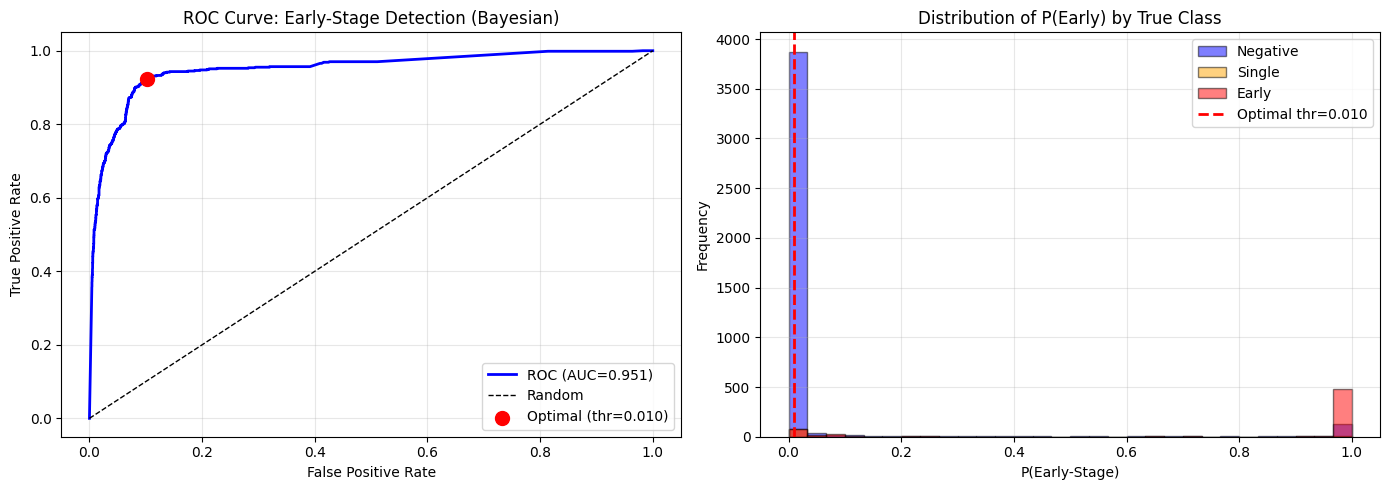

In [11]:

# Visualization: ROC curve and probability distributions

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC curve
ax = axes[0]
fpr, tpr, thresholds_roc = roc_curve(bayes_df["y_early_true"], bayes_df["P_early"])
ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC={bayes_roc_auc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.scatter([optimal_fpr], [optimal_tpr], color='red', s=100, marker='o', 
           label=f'Optimal (thr={optimal_threshold:.3f})', zorder=5)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve: Early-Stage Detection (Bayesian)')
ax.legend()
ax.grid(True, alpha=0.3)

# Probability distributions by true class
ax = axes[1]
for class_val, label, color in [(0, 'Negative', 'blue'), (1, 'Single', 'orange'), (2, 'Early', 'red')]:
    p_early_class = bayes_df[bayes_df["y_class"] == class_val]["P_early"]
    ax.hist(p_early_class, bins=30, alpha=0.5, label=label, color=color, edgecolor='black')

ax.axvline(optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal thr={optimal_threshold:.3f}')
ax.set_xlabel('P(Early-Stage)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of P(Early) by True Class')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bayes_evaluation.png', dpi=300, bbox_inches='tight')
print("Saved plot to `bayes_evaluation.png`")
plt.show()
